<a href="https://colab.research.google.com/github/NikNord174/GAN_sandbox/blob/main/Conditional%20GAN_PaperStoneScissors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditional GAN

In [1]:
import tensorflow_datasets as tfds
ds_train = tfds.load(name = "rock_paper_scissors", split="train")

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import PIL
import numpy as np

class PSR(Dataset):
    def __init__(self):
        self.samples = []
        self.labels=[]
        self.train_transform=Compose([
                                    Resize(128),
                                    ToTensor(),
                                    Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
                                    ])
        for example in ds_train:
          self.samples.append(example['image'].numpy())
          self.labels.append(example['label'].numpy())


    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img=PIL.Image.fromarray(np.uint8(self.samples[idx]))
        img=self.train_transform(img)
        label=self.labels[idx]
        return img, label

In [3]:
train_loader=torch.utils.data.DataLoader(dataset=PSR(), batch_size=10, shuffle=True)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:493: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


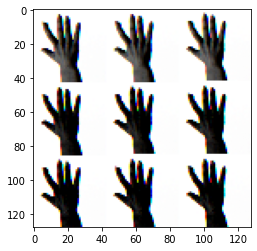

In [4]:
import matplotlib.pyplot as plt

for idx,(im,lab) in enumerate(train_loader):
  plt.imshow(im[0].resize(128,128,3))
  break

In [5]:
image_shape=(3,128,128)
latent_dim=100
image_dim=int(np.prod(image_shape))
n_classes=3
embedding_dim=3
lr=0.05
b1=0.5
b2=0.999

In [6]:
def weights_init(m):
  classname=m.__class__.__name__
  if classname.find('Conv')!=-1:
    torch.nn.init.normal_(m.weight,0.0,0.02)
  elif classname.find('BatchNorm')!=-1:
    torch.nn.init.normal_(m.weight,1.0,0.02)
    torch.nn.init.zeros_(m.bias)

In [7]:
from torch import nn

class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    self.label_conditioned_generator=nn.Sequential(
        nn.Embedding(n_classes, embedding_dim),
        nn.Linear(embedding_dim,16)
        )
    
    self.latent=nn.Sequential(
        nn.Linear(latent_dim,4*4*512),
        nn.LeakyReLU(0.2,inplace=True)
    )

    self.model=nn.Sequential(
        nn.ConvTranspose2d(513,64*8,4,2,1,bias=False),
        nn.BatchNorm2d(64*8, momentum=0.1, eps=0.8),
        nn.ReLU(True),
        nn.ConvTranspose2d(64*8,64*4,4,2,1,bias=False),
        nn.BatchNorm2d(64*4, momentum=0.1, eps=0.8),
        nn.ReLU(True),
        nn.ConvTranspose2d(64*4,64*2,4,2,1,bias=False),
        nn.BatchNorm2d(64*2, momentum=0.1, eps=0.8),
        nn.ReLU(True),
        nn.ConvTranspose2d(64*2,64*1,4,2,1,bias=False),
        nn.BatchNorm2d(64*1, momentum=0.1, eps=0.8),
        nn.ReLU(True),
        nn.ConvTranspose2d(64*1,3,4,2,1,bias=False),
        nn.Tanh()
        )
    
  def forward(self, inputs):
    noise_vector,label=inputs
    label_output=self.label_conditioned_generator(label)
    label_output=label_output.view(-1,1,4,4)
    latent_output=self.latent(noise_vector)
    latent_output=latent_output.view(-1,512,4,4)
    concat=torch.cat((latent_output, label_output),dim=1)
    image=self.model(concat)
    return image

In [13]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.label_condition_disc=nn.Sequential(
        nn.Embedding(n_classes,embedding_dim),
        nn.Linear(embedding_dim,3*128*128)
        )
    
    self.model=nn.Sequential(
        nn.Conv2d(6,64,4,2,1,bias=False),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(64,64*2,4,2,1,bias=False),
        #nn.BatchNorm2d(64*2, momentum=0.1, eps=0.8),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(64*2,64*4,4,2,1,bias=False),
        #nn.BatchNorm2d(64*4, momentum=0.1, eps=0.8),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(64*4,64*8,4,2,1,bias=False),
        #nn.BatchNorm2d(64*8, momentum=0.1, eps=0.8),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Flatten(),
        nn.Dropout(0.7),
        nn.Linear(32768,1),
        nn.Sigmoid()
        )
    
  def forward(self,inputs):
    img,label=inputs
    label_output=self.label_condition_disc(label)
    label_output=label_output.view(-1,3,128,128)
    concat=torch.cat((img,label_output),dim=1)
    output=self.model(concat)
    return output

In [20]:
loss_function=nn.BCELoss()

def generator_loss(fake_output,label):
  gen_loss=loss_function(fake_output,label)
  return gen_loss

def discriminator_loss(output,label):
  disc_loss=loss_function(output,label)
  return disc_loss

import torch.optim as optim

device=torch.device('cpu')# if torch.cuda.is_available() else 'cpu')

generator=Generator().to(device)
generator.apply(weights_init)
discriminator=Discriminator().to(device)
discriminator.apply(weights_init)

G_optimizer=optim.Adam(generator.parameters(), lr=lr, betas=(b1,b2))
D_optimizer=optim.Adam(discriminator.parameters(),lr=lr,betas=(b1,b2))

In [10]:
#!mkdir results

In [17]:
torch.cuda.empty_cache()
#torch.cuda.memory_summary(device=None, abbreviated=False)

In [ ]:
from torchvision.utils import save_image

n_epochs=3
D_loss_plot=[]
G_loss_plot=[]
for epoch in range(1,n_epochs+1):
  D_loss_list=[]
  G_loss_list=[]
  #batch=0.0
  for index, (real_images, labels) in enumerate(train_loader):
    #batch+=1.0
    #print(batch)
    D_optimizer.zero_grad()
    real_images=real_images.to(device)
    labels=labels.to(device)
    labels=labels.unsqueeze(1).long()

    real_target=torch.ones(real_images.size(0),1).to(device)
    fake_target=torch.zeros(real_images.size(0),1).to(device)

    output=discriminator((real_images,labels))
    D_real_loss=discriminator_loss(output,real_target)
    #D_real_loss.backward(retain_graph=True)

    noise_vector=torch.randn(real_images.size(0),latent_dim,device=device)
    noise_vector=noise_vector.to(device)

    generated_image=generator((noise_vector,labels))
    output=discriminator((generated_image.detach(),labels))
    D_fake_loss=discriminator_loss(output,fake_target)

    D_total_loss=(D_real_loss+D_fake_loss)/2
    D_loss_list.append(D_total_loss)

    D_total_loss.backward(retain_graph=True)
    D_optimizer.step()

    G_optimizer.zero_grad()
    G_loss=generator_loss(discriminator((generated_image,labels)),real_target)
    G_loss_list.append(G_loss)

    G_loss.backward()
    G_optimizer.step()

  print('Epoch: [%d/%d]: D_loss: %.3f, G_loss: %.3f' %(epoch,n_epochs,
                                                       torch.mean(torch.FloatTensor(D_loss_list)),
                                                       torch.mean(torch.FloatTensor(G_loss_list))))
  
  D_loss_plot.append(torch.mean(torch.FloatTensor(D_loss_list)))
  G_loss_plot.append(torch.mean(torch.FloatTensor(G_loss_list)))
  save_image(generated_image.data,'/content/results/sample_%d'%epoch + '.png')
   